source http://srome.github.io/Leveraging-Factorization-Machines-for-Sparse-Data-and-Supervised-Visualization/

In [1]:
%load_ext autotime

# Load author's lib

In [2]:
import itertools
from collections import namedtuple

import numpy as np
import theano
from theano import tensor as T
from theano import sparse as S


_Weights = namedtuple('_Weights', ['w0', 'w1', 'v'])


class _FactorizationMachine(object):
    """Base class for factorization machines.

    Warning: This class should not be used directly. Use derived classes
    instead (FactorizationMachineClassifier and FactorizationMachineRegressor).
    """
    def __init__(self,
                 feature_count,
                 classifier=False,
                 k = 8,
                 stdev = 0.1,
                 sparse = False):
        self.classifier = classifier
        d = feature_count

        # *** Symbolic variables ***
        if sparse:
            X = S.csr_matrix(name='inputs', dtype='float32')
        else:
            X = T.matrix()
        y = T.vector()
        beta_w1 = T.scalar()
        beta_v = T.scalar()

        # *** Model parameters ***
        # bias term (intercept)
        w0_init = np.zeros(1)
        self.w0 = theano.shared(w0_init, allow_downcast=True)
        # first order coefficients
        w1_init = np.zeros(d)
        self.w1 = theano.shared(w1_init, allow_downcast=True)
        # interaction factors
        v_init = stdev * np.random.randn(k, d)
        self.v = theano.shared(v_init, allow_downcast=True)

        # *** The Model ***
        # The formula for pairwise interactions is from the bottom left
        # of page 997 of Rendle 2010, "Factorization Machines."
        # This version scales linearly in k and d, as opposed to O(d^2).
        if sparse:
            interactions = 0.5 * T.sum((S.dot(X, T.transpose(self.v)) ** 2) - \
                                       S.dot(S.mul(X,X), T.transpose(self.v ** 2)), axis=1)
            y_hat = T.addbroadcast(self.w0,0) + S.dot(X, self.w1) + interactions
        else:
            interactions = 0.5 * T.sum((T.dot(X, T.transpose(self.v)) ** 2) - \
                                       T.dot(X ** 2, T.transpose(self.v ** 2)), axis=1)
            y_hat = T.addbroadcast(self.w0,0) + T.dot(X, self.w1) + interactions
        if self.classifier:
            y_hat = T.nnet.sigmoid(y_hat)

        # *** Loss Function ***
        if self.classifier:
            error = T.mean(T.nnet.binary_crossentropy(y_hat, y))
        else:
            error = T.mean((y - y_hat)**2)
        # regularization
        L2 = beta_w1 * T.mean(self.w1 ** 2) + beta_v * T.mean(self.v ** 2)
        loss = error + L2

        # *** Learning ***
        updates = []
        params = [self.w0, self.w1, self.v]
        grads = T.grad(cost=loss, wrt=params)
        # RMSProp
        lr, rho, epsilon = 0.001, 0.9, 1e-6
        for p, g in zip(params, grads):
            acc = theano.shared(p.get_value() * 0.)
            acc_new = rho * acc + (1 - rho) * g ** 2
            gradient_scaling = T.sqrt(acc_new + epsilon)
            g = g / gradient_scaling
            updates.append((acc, acc_new))
            updates.append((p, p - lr * g))

        self.theano_train = theano.function(
            inputs=[X, y, beta_w1, beta_v], outputs=loss, updates=updates, allow_input_downcast=True)

        self.theano_cost = theano.function(
            inputs=[X, y, beta_w1, beta_v], outputs=loss, allow_input_downcast=True)

        # *** Prediction ***
        self.theano_predict = theano.function(
            inputs=[X], outputs=y_hat, allow_input_downcast=True)


    def get_weights(self):
        """Returns a _Weights namedtuple"""
        return _Weights(*(w.get_value() for w in (self.w0, self.w1, self.v)))


    def set_weights(self, weights):
        """Sets weights from a _Weights namedtuple"""
        self.w0.set_value(weights.w0)
        self.w1.set_value(weights.w1)
        self.v.set_value(weights.v)


    def fit(self, X, y,
            batch_size=50,
            nb_epoch=10,
            shuffle=True,
            verbose=False,
            beta_w1=0.0,
            beta_v=0.0):
        """Learns the weights of a factorization machine with mini-batch gradient
        descent. The weights that minimize the loss function (across epochs) are
        retained."""
        n = X.shape[0]
        if batch_size > n:
            batch_size = n
        min_loss = float('inf')
        min_loss_weights = self.get_weights()
        for i in range(nb_epoch):
            if shuffle:
                indices = np.arange(n)
                np.random.shuffle(indices)
                X, y = X[indices], y[indices]
            for start in itertools.count(0, batch_size):
                if start >= n:
                    break
                stop = min(start + batch_size, n)
                self.theano_train(X[start:stop], y[start:stop], beta_w1, beta_v)
            current_loss = self.theano_cost(X, y, beta_w1, beta_v)
            if current_loss < min_loss:
                min_loss = current_loss
                min_loss_weights = self.get_weights()
            if verbose:
                print('Epoch {}/{}'.format(i+1, nb_epoch))
                print(' loss: {}, min_loss: {}'.format(current_loss, min_loss))
        self.set_weights(min_loss_weights)


    def save(self, path):
        with open(path, 'wb') as f:
            w0, w1, v = self.get_weights()
            np.savez(
                f, classifier=self.classifier, w0=w0, w1=w1, v=v)


class FactorizationMachineClassifier(_FactorizationMachine, object):
    """A factorization machine classifier."""
    def __init__(self, *args, **kwargs):
        kwargs['classifier'] = True
        super(FactorizationMachineClassifier, self).__init__(*args, **kwargs)


    def predict(self, X):
        return (self.theano_predict(X) > 0.5).astype(np.int)


    def predict_proba(self, X):
        return self.theano_predict(X)


class FactorizationMachineRegressor(_FactorizationMachine, object):
    """A factorization machine regressor."""
    def __init__(self, *args, **kwargs):
        kwargs['classifier'] = False
        super(FactorizationMachineRegressor, self).__init__(*args, **kwargs)


    def predict(self, X):
        return self.theano_predict(X)


def load(path):
    meta = np.load(path)
    classifier = meta['classifier']
    weights = _Weights(*[meta[key] for key in ['w0', 'w1', 'v']])
    k, d = weights.v.shape
    cls = FactorizationMachineClassifier if classifier else FactorizationMachineRegressor
    model = cls(d, k=k)
    model.set_weights(weights)
    return model

time: 1.72 s


# Import Data & Simple Manipulate

In [3]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', 
                                  shuffle=True, 
                                  random_state=42)

time: 424 ms


In [4]:
import pandas as pd
def define_label(x, target_names):
    name = target_names[x]
    return 1 if 'comp' in name else 0
    
target = pd.Series(twenty_train.target).apply(lambda x : define_label(x,twenty_train.target_names))
target.mean() # Prevalence of the label

0.25950150256319604

time: 610 ms


In [5]:
def clean_text(text):
    # Basic cleaning
    text=text.replace('\n','').replace('\t','').replace('<','').replace('>','').replace('|','')
    return [x for x in text.split(' ') if len(x) > 3]

X = [clean_text(x) for x in twenty_train.data]

from sklearn.feature_extraction import FeatureHasher

# Hash away!
fh = FeatureHasher(input_type='string')
X_t = fh.transform(X)

# Bin the inputs so that the "interaction" terms are more interpretable
X_bin = X_t.copy()
X_bin[X_bin >= 1] = 1


time: 1.36 s


# Use Factorization Machine

In [6]:
from sklearn.model_selection import train_test_split

f = FactorizationMachineClassifier(X_t.shape[1], sparse=True)
X_train, X_test, y_train, y_test = train_test_split(X_bin, target, test_size=0.33, random_state=42)

f.fit(X_train, y_train, beta_w1=.01, beta_v=.01, nb_epoch=20, verbose=True, batch_size=250, shuffle=False)

Epoch 1/20
 loss: 0.5067896055493897, min_loss: 0.5067896055493897
Epoch 2/20
 loss: 0.2992355629757832, min_loss: 0.2992355629757832
Epoch 3/20
 loss: 0.19752477294309753, min_loss: 0.19752477294309753
Epoch 4/20
 loss: 0.14242225502759606, min_loss: 0.14242225502759606
Epoch 5/20
 loss: 0.10944646312404847, min_loss: 0.10944646312404847
Epoch 6/20
 loss: 0.08814821934036131, min_loss: 0.08814821934036131
Epoch 7/20
 loss: 0.0730615290179662, min_loss: 0.0730615290179662
Epoch 8/20
 loss: 0.06192470337594915, min_loss: 0.06192470337594915
Epoch 9/20
 loss: 0.05338422762278244, min_loss: 0.05338422762278244
Epoch 10/20
 loss: 0.04665410144437181, min_loss: 0.04665410144437181
Epoch 11/20
 loss: 0.04122573907945251, min_loss: 0.04122573907945251
Epoch 12/20
 loss: 0.036764170292268084, min_loss: 0.036764170292268084
Epoch 13/20
 loss: 0.033039440202278766, min_loss: 0.033039440202278766
Epoch 14/20
 loss: 0.02988827423463166, min_loss: 0.02988827423463166
Epoch 15/20
 loss: 0.0271919608

In [7]:
from sklearn.metrics import classification_report
pred = f.predict(X_test)

print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2786
           1       0.76      0.62      0.68       948

    accuracy                           0.85      3734
   macro avg       0.82      0.78      0.79      3734
weighted avg       0.85      0.85      0.85      3734

time: 114 ms


# Use SVD

In [8]:
# LSA-based approach
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
import numpy as np

# Get the same training data for LSA
X_train, X_test, y_train, y_test = train_test_split(X_t, target, test_size=0.33, random_state=42)

tfidf = TfidfTransformer()
X_lsa = tfidf.fit_transform(X_train)
svd=TruncatedSVD(n_components=3)
M = np.transpose(svd.fit_transform(np.transpose(X_lsa)))

# V from Factorization Model
V=f.v.get_value().copy()

time: 3.29 s


# Visualization

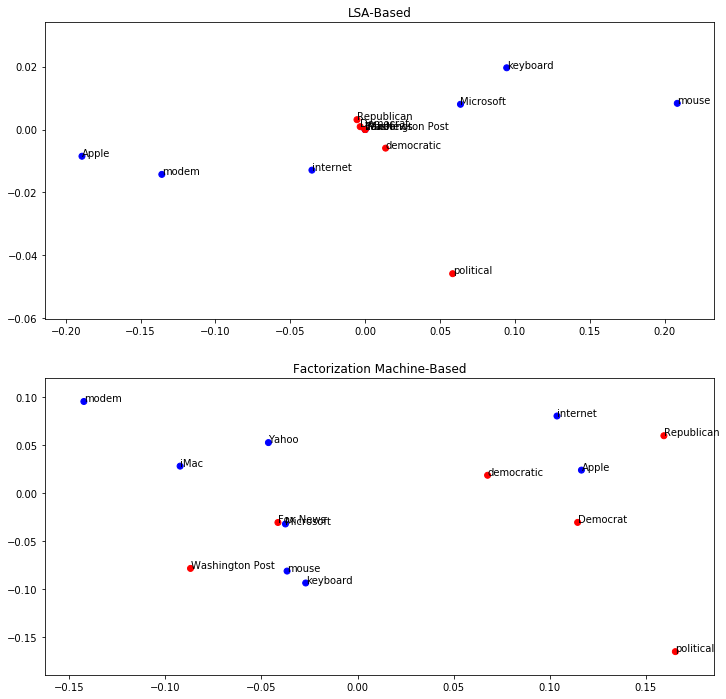

time: 1.24 s


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Fit the model to the data to learn V
from sklearn.feature_extraction import _hashing # The hashing function we used

words = {}

# Terms that might be found in sci/comp
for word in ['keyboard', 'Microsoft', 'iMac','Apple',
             'internet', 'Yahoo', 'modem','mouse']:
    indx = fh.transform([[word]]).indices[0]
    words[indx] = (word, 1)

# Terms in the other groups, probably
for word in ['Republican',
             'Washington Post', 'Fox News',
             'political','Democrat','democratic']:
    indx = fh.transform([[word]]).indices[0]
    words[indx] = (word, 0)

def visualize_words_from_matrix(matrix, words, ax):
    # Plot the word's locations colored by label
    x = [matrix[1, k]  for k in words.keys()]
    y = [matrix[2, k]  for k in words.keys()]
    color = ['b' if x[1] else 'r' for x in words.values()]
    ax.scatter(x,y, color = color)

    # Add the words to the plot
    for i, v in words.items():
        word, target_class = v
        ax.annotate(word, (matrix[1, i], matrix[2, i]))

fig, ax = plt.subplots(2, figsize=(12,12))
ax[0].set_title('LSA-Based')
visualize_words_from_matrix(M, words, ax[0])
ax[1].set_title('Factorization Machine-Based')
visualize_words_from_matrix(V, words, ax[1])